/ext3/miniconda3/lib/python3.9/site-packages/MDAnalysis/topology/LAMMPSParser.py:631: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')


MSD did not reach 1 at temperature 1.5


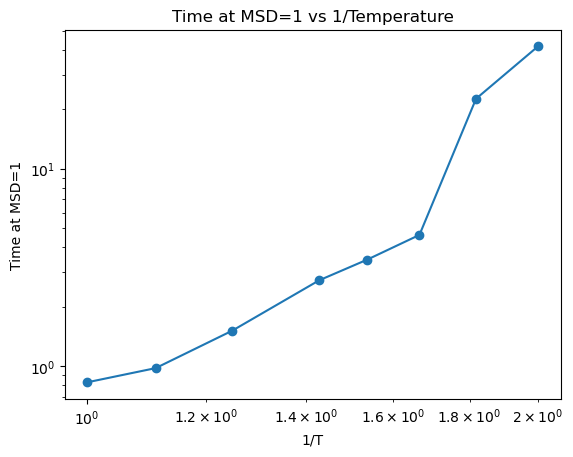

In [2]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import os
from MDAnalysis.analysis.rdf import InterRDF

# Create output directory for figures
figures_dir = "./Figures/n360/"
os.makedirs(figures_dir, exist_ok=True)

# Define the temperature files for n360
temperature_files = {
    1.5: "kalj_T1.5_n360_v300_prod_10000_1",
    1.0: "kalj_T1_n360_v300_prod_50000_1",
    0.9: "kalj_T0.9_n360_v300_prod_150000_1",
    0.8: "kalj_T0.8_n360_v300_prod_150000_1",
    0.7: "kalj_T0.7_n360_v300_prod_180000_1",
    0.65: "kalj_T0.65_n360_v300_prod_350000_1",
    0.6: "kalj_T0.6_n360_v300_prod_1000000_1",
    0.55: "kalj_T0.55_n360_v300_prod_3000000_1",
    0.5: "kalj_T0.5_n360_v300_prod_10000000_1",
}

# Target MSD value
target_msd = 1

# Containers for results
msd1_times = []  # Times where MSD = 1
valid_temperatures = []  # Corresponding temperatures

# Compute MSD and RDF for each temperature
for T, filename in temperature_files.items():
    try:
        # File paths
        equil_file = f"/home/ndv3235/comp-lab-class-2024/Week9-LAMMPS-SupercooledLiquids/Data/Equilibrium/{filename.replace('_prod_', '_')}.lammpstrj"
        prod_file = f"/home/ndv3235/comp-lab-class-2024/Week9-LAMMPS-SupercooledLiquids/Data/Production/{filename}.unwrap.dcd"

        # Load the Universe
        universe = mda.Universe(equil_file, prod_file, topology_format="LAMMPSDUMP")
        type1 = universe.select_atoms("type 1")
        type2 = universe.select_atoms("type 2")

        # Compute MSD
        n_frames = len(universe.trajectory)
        msd = np.zeros(n_frames)
        time = np.arange(n_frames) * universe.trajectory.dt

        initial_positions = type1.positions.copy()  # Reference positions

        for ts in universe.trajectory:
            displacements = type1.positions - initial_positions
            squared_displacements = np.sum(displacements ** 2, axis=1)
            msd[ts.frame] = np.mean(squared_displacements)

        # Plot MSD
        plt.figure()
        plt.loglog(time, msd, label=f"T={T}")
        plt.xlabel("Time (log scale)")
        plt.ylabel("MSD (log scale)")
        plt.title(f"MSD for Type 1 Particles at T={T}")
        plt.legend()
        plt.savefig(f"{figures_dir}/MSD_T{T}.png")
        plt.close()

        # Find time where MSD = 1
        indices = np.where(msd >= target_msd)[0]
        if len(indices) > 0:
            time_msd1 = time[indices[0]]
            msd1_times.append(time_msd1)
            valid_temperatures.append(T)
        else:
            print(f"MSD did not reach {target_msd} at temperature {T}")

        # Compute RDF
        rdf_11 = InterRDF(type1, type1)
        rdf_22 = InterRDF(type2, type2)
        rdf_12 = InterRDF(type1, type2)

        rdf_11.run()
        rdf_22.run()
        rdf_12.run()

        # Plot RDF
        plt.figure()
        plt.plot(rdf_11.results.bins, rdf_11.results.rdf, label="g_11(r)")
        plt.plot(rdf_22.results.bins, rdf_22.results.rdf, label="g_22(r)")
        plt.plot(rdf_12.results.bins, rdf_12.results.rdf, label="g_12(r)")
        plt.xlabel("r (distance)")
        plt.ylabel("g(r)")
        plt.title(f"RDF at T={T}")
        plt.legend()
        plt.savefig(f"{figures_dir}/RDF_T{T}.png")
        plt.close()

    except Exception as e:
        print(f"Error processing temperature {T}: {e}")
        continue

# Plot Time at MSD=1 vs 1/T
inverse_temperatures = 1 / np.array(valid_temperatures)
plt.figure()
plt.loglog(inverse_temperatures, msd1_times, marker='o')
plt.xlabel("1/T")
plt.ylabel("Time at MSD=1")
plt.title("Time at MSD=1 vs 1/Temperature")
plt.savefig(f"{figures_dir}/Time_at_MSD_1_vs_1_over_T.png")
plt.show()